In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import sys
sys.path.append('../learnMSA')
import numpy as np
from learnMSA import msa_hmm
from matplotlib import pyplot as plt

## MSA HMM Interactive

1. Fit n models, keep the best and align
2. Compare to a reference
3. Visualize the HMM

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.
#train_filename = "../MSA-HMM-Analysis/data/homfam/train/msb.fasta"
train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
#ref_filename = "../MSA-HMM-Analysis/data/homfam/refs/msb.ref"
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

## Training

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

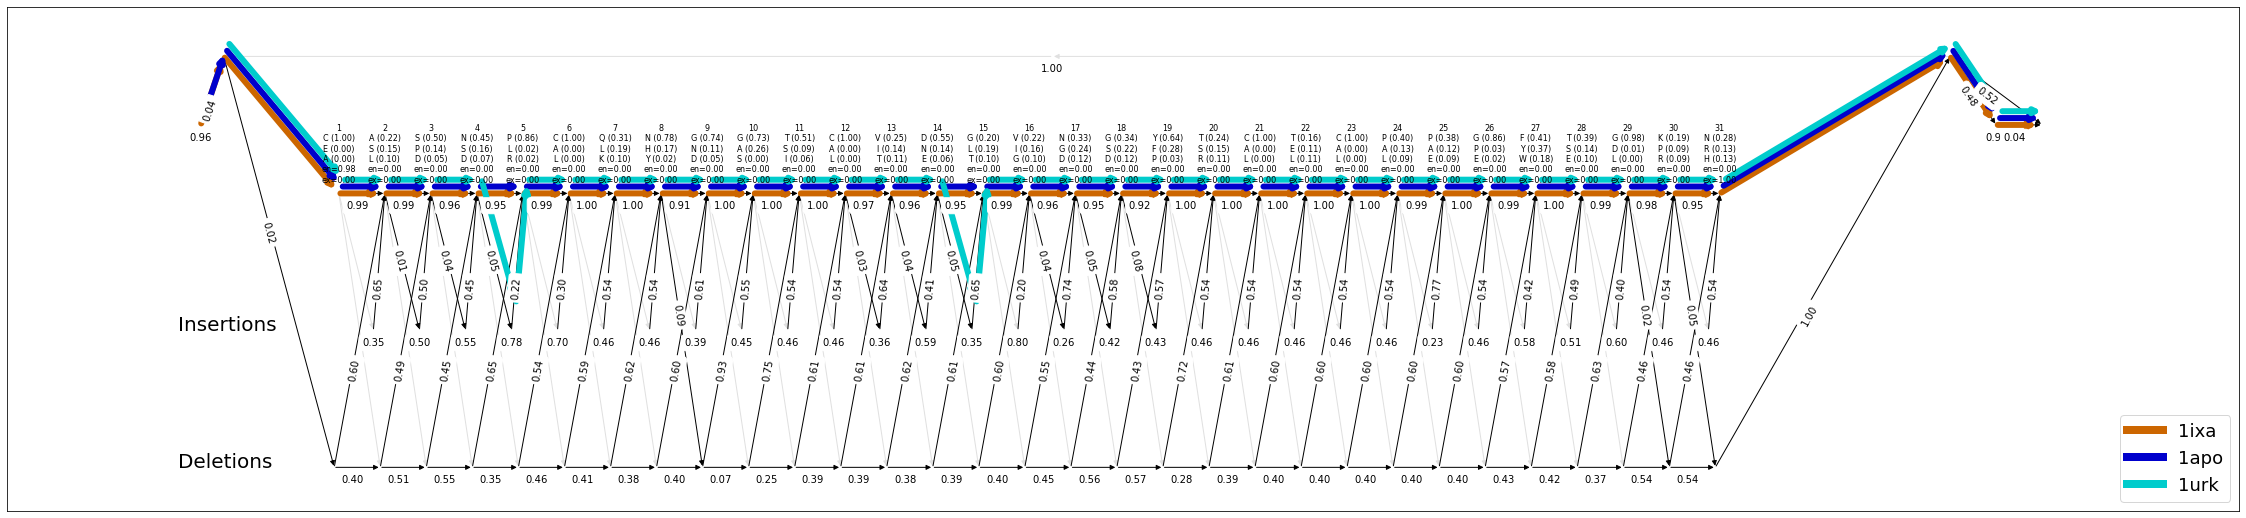

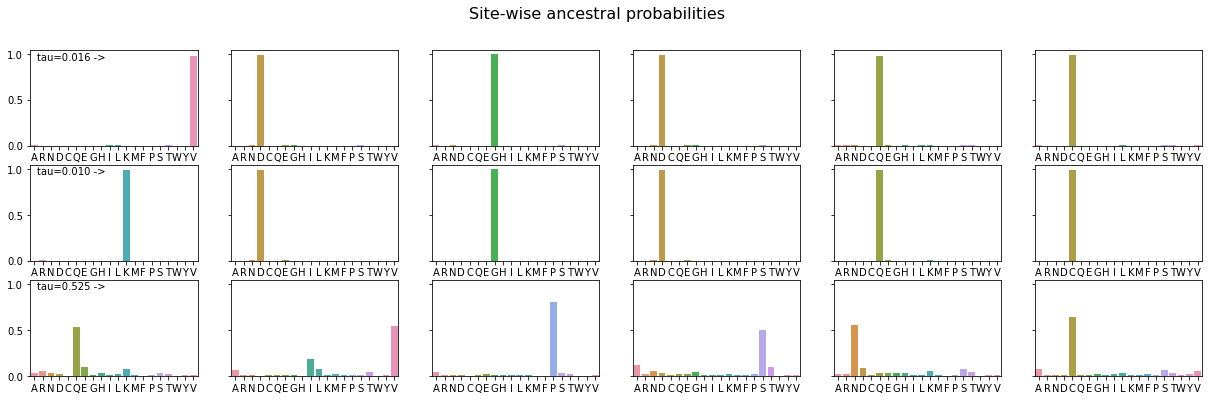

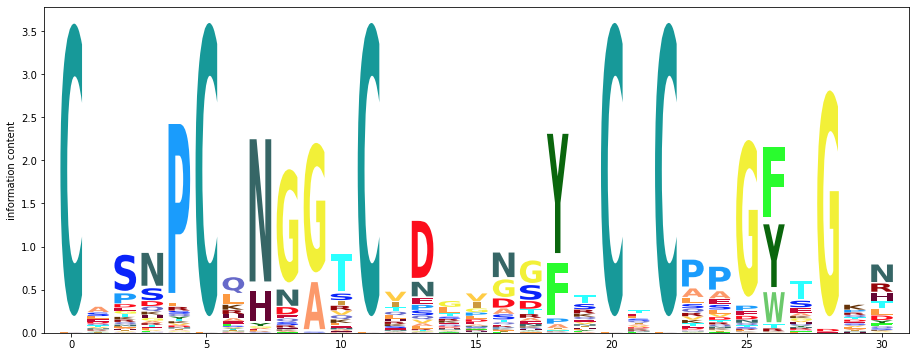

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = msa_hmm.config.make_default(num_models)
alignment_model, r = msa_hmm.align.run_learnMSA(train_filename,
                                                  out_filename,
                                                  config, 
                                                  ref_filename=ref_filename, 
                                                  verbose=True,
                                                  select_best_for_comparison=False)
msa_hmm.vis.print_and_plot(alignment_model, alignment_model.best_model)